# Water Distribution Simulation Visualization

This notebook visualizes results from the WNTR-based water distribution simulation.

In [1]:
import json
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import wntr

# Add src to path
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

# local imports
from src.water_distribution_simulation.preprocessing import load_network, load_config

# import matplot style from data/input/ploting.mplstyle
plt.style.use(project_root / 'data' / 'inputs' / 'plotting.mplstyle')    

/Users/abdelrahmanaltawil/miniforge3/envs/py310_env/lib/python3.10/site-packages/wntr/epanet/toolkit.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


## 1. Load Simulation Results

Load the most recent simulation run results.

In [2]:
# Find most recent simulation run
results_dir = project_root / 'data' / 'results' / 'water_distribution_simulation'

if results_dir.exists() and results_dir.is_dir():
    run_dirs = sorted([d for d in results_dir.iterdir() if d.is_dir()], reverse=True)
    if run_dirs:
        run_dir = run_dirs[0]
        config_path = run_dir / 'config.yaml'
        print(f"Loading results from: {run_dir.name}")
    else:
        print("No simulation runs found. Run the simulation first.")
        run_dir = None
else:
    print(f"Results directory not found: {results_dir}")
    run_dir = None

Loading results from: run_20260111_230319


In [3]:
if run_dir:
    # Load configuration
    config = load_config(str(config_path))
    inp_file_path = run_dir / Path(config['network']['inp_file']).name

    # Load simulation setup options
    wn = load_network(str(inp_file_path))
    
    # Load node results
    pressure_df = pd.read_csv(run_dir / 'nodes' / 'pressure.csv', index_col=0)
    demand_df = pd.read_csv(run_dir / 'nodes' / 'demand.csv', index_col=0)
    head_df = pd.read_csv(run_dir / 'nodes' / 'head.csv', index_col=0)
    
    # Load link results
    flowrate_df = pd.read_csv(run_dir / 'links' / 'flowrate.csv', index_col=0)
    velocity_df = pd.read_csv(run_dir / 'links' / 'velocity.csv', index_col=0)
    
    # Load metrics and metadata
    with open(run_dir / 'summary.json', 'r') as f:
        summary = json.load(f)
    
    # Convert index to hours
    pressure_df.index = pressure_df.index.astype(float) / 3600
    demand_df.index = demand_df.index.astype(float) / 3600
    flowrate_df.index = flowrate_df.index.astype(float) / 3600

    # Print summary
    print(f"Loaded simulation with duration of {summary['network']['duration_hours']} hours")
    print(f"Network: {summary['network']['num_nodes']} nodes, {summary['network']['num_links']} links")

Loaded simulation with duration of 35.0 hours
Network: 263 nodes, 289 links


## 2. Network Visualization

WATER DISTRIBUTION NETWORK - COMPONENT SUMMARY

                           NODES                            
------------------------------------------------------------
  Junctions:     262  ['1', '2', '3', '4', '5'] ...
  Reservoirs:      1  ['410']
  Tanks:           0  []

                           LINKS                            
------------------------------------------------------------
  Pipes:         288  ['1', '2', '3', '4', '5'] ...
  Pumps:           1  ['2359']
  Valves:          0  []


/Users/abdelrahmanaltawil/miniforge3/envs/py310_env/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


AttributeError: `np.alltrue` was removed in the NumPy 2.0 release. Use `np.all` instead.

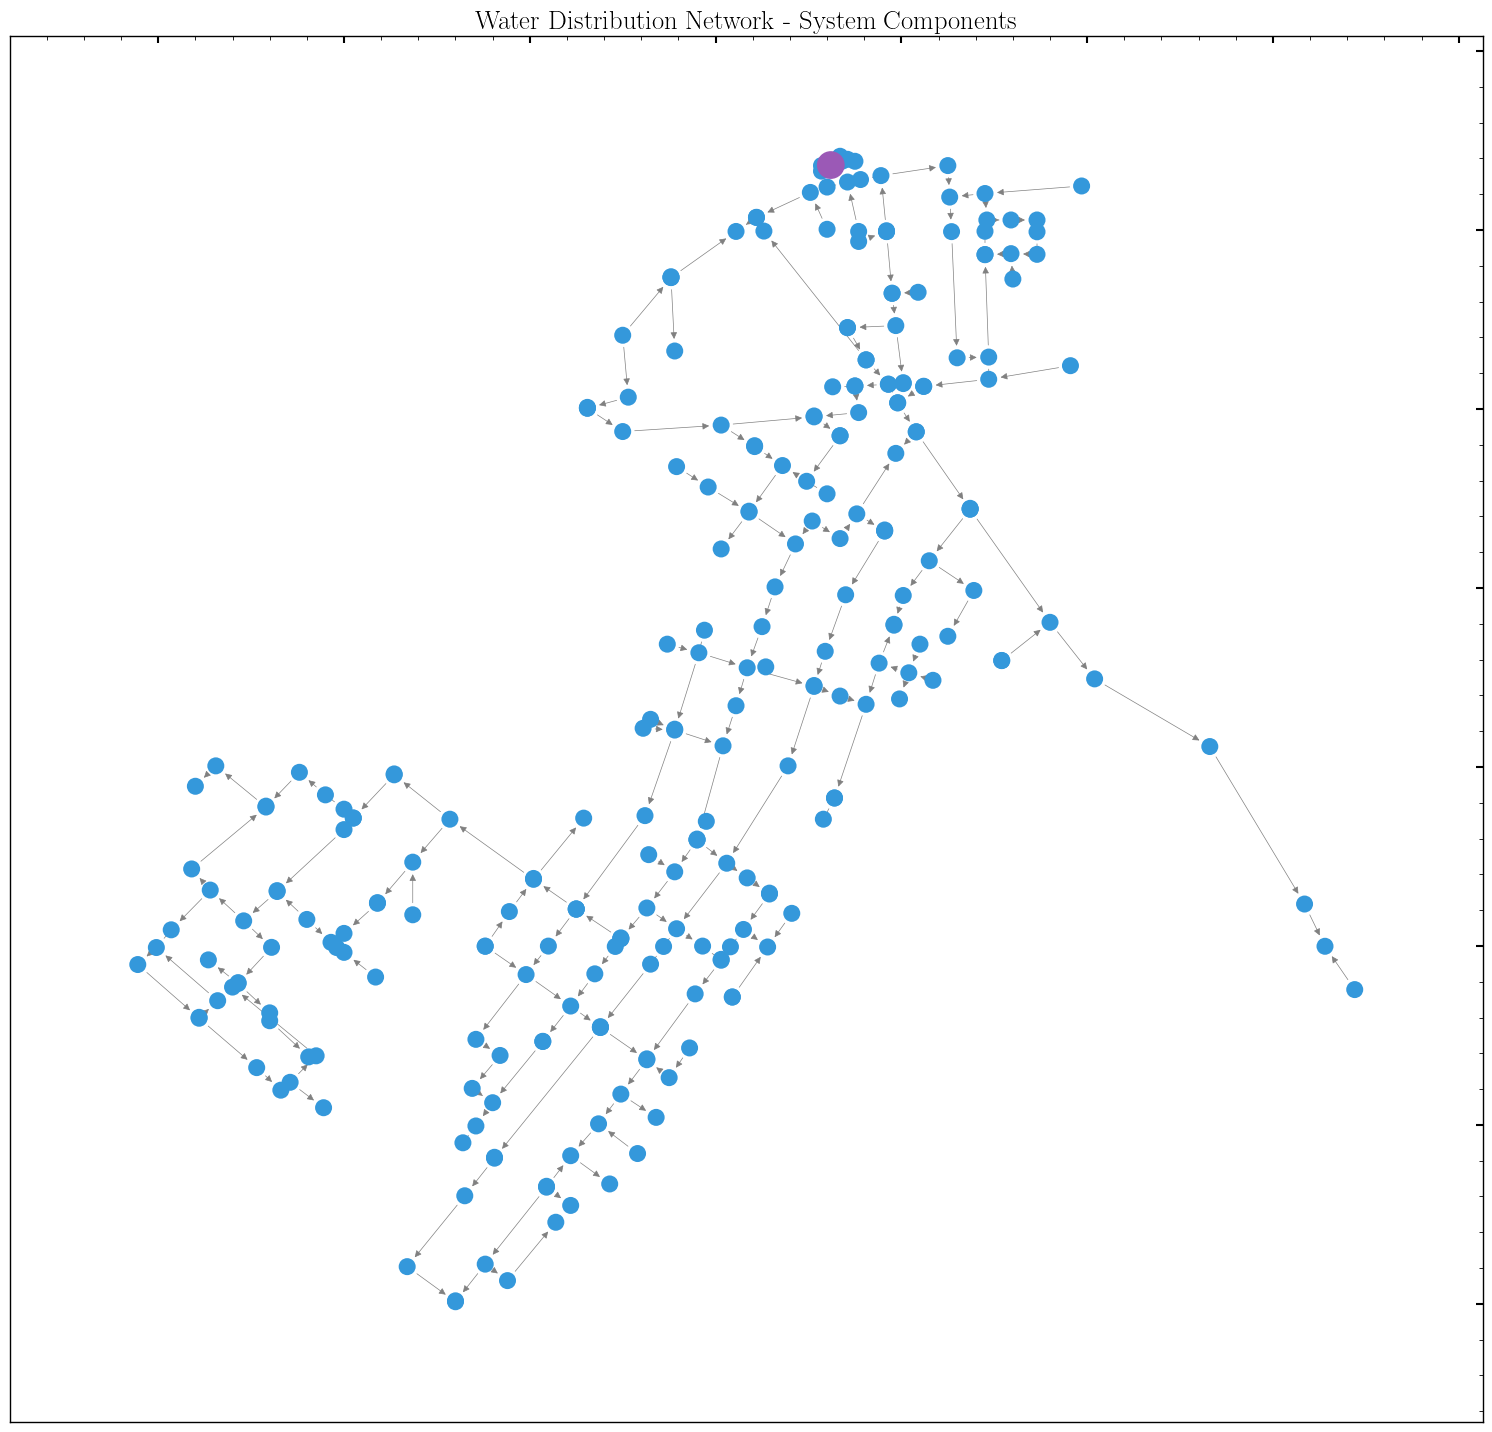

In [5]:
def print_network_summary(wn):
    """
    Print a summary of network components.
    
    Parameters
    ----------
    wn : wntr.network.WaterNetworkModel
        Water network model object
    """
    # Get node information by type
    junction_names = wn.junction_name_list
    reservoir_names = wn.reservoir_name_list
    tank_names = wn.tank_name_list
    
    # Get link information by type
    pipe_names = wn.pipe_name_list
    pump_names = wn.pump_name_list
    valve_names = wn.valve_name_list
    
    print("=" * 60)
    print("WATER DISTRIBUTION NETWORK - COMPONENT SUMMARY")
    print("=" * 60)
    print(f"\n{'NODES':^60}")
    print("-" * 60)
    print(f"  Junctions:   {len(junction_names):>5}  {junction_names if len(junction_names) <= 10 else str(junction_names[:5]) + ' ...'}")
    print(f"  Reservoirs:  {len(reservoir_names):>5}  {reservoir_names}")
    print(f"  Tanks:       {len(tank_names):>5}  {tank_names}")
    print(f"\n{'LINKS':^60}")
    print("-" * 60)
    print(f"  Pipes:       {len(pipe_names):>5}  {pipe_names if len(pipe_names) <= 10 else str(pipe_names[:5]) + ' ...'}")
    print(f"  Pumps:       {len(pump_names):>5}  {pump_names}")
    print(f"  Valves:      {len(valve_names):>5}  {valve_names}")
    print("=" * 60)


def print_detailed_component_info(wn):
    """
    Print detailed information about network components.
    
    Parameters
    ----------
    wn : wntr.network.WaterNetworkModel
        Water network model object
    """
    reservoir_names = wn.reservoir_name_list
    tank_names = wn.tank_name_list
    pump_names = wn.pump_name_list
    valve_names = wn.valve_name_list
    
    print("\n" + "=" * 60)
    print("DETAILED COMPONENT INFORMATION")
    print("=" * 60)
    
    # Reservoir details
    if reservoir_names:
        print("\n** RESERVOIRS (Infinite Water Sources) **")
        print("   Reservoirs provide unlimited water supply to the network.")
        print("   They maintain a constant hydraulic head regardless of flow.")
        for name in reservoir_names:
            res = wn.get_node(name)
            print(f"   {name}: Head = {res.head_timeseries.base_value:.2f} m, "
                  f"Coordinates = {res.coordinates}")
    
    # Tank details
    if tank_names:
        print("\n** TANKS (Water Storage) **")
        print("   Tanks store water and their level changes based on inflow/outflow.")
        print("   They have minimum and maximum level constraints.")
        for name in tank_names:
            tank = wn.get_node(name)
            print(f"   {name}: Init Level = {tank.init_level:.2f} m, "
                  f"Min = {tank.min_level:.2f} m, Max = {tank.max_level:.2f} m, "
                  f"Diameter = {tank.diameter:.2f} m")
    
    # Pump details
    if pump_names:
        print("\n** PUMPS (Active Components) **")
        print("   Pumps add energy to the system to move water.")
        print("   They can be controlled by patterns, rules, or controls.")
        for name in pump_names:
            pump = wn.get_link(name)
            print(f"   {name}: From {pump.start_node_name} -> To {pump.end_node_name}")
    
    # Valve details
    if valve_names:
        print("\n** VALVES (Control Components) **")
        print("   Valves control flow or pressure in the network.")
        print("   Types include PRV, PSV, PBV, FCV, TCV, GPV.")
        for name in valve_names:
            valve = wn.get_link(name)
            print(f"   {name}: Type = {valve.valve_type}, "
                  f"From {valve.start_node_name} -> To {valve.end_node_name}")
    
    print("\n" + "=" * 60)


def plot_network_with_components(wn, figsize=(14, 12), node_labels=True, 
                                  show_legend=True, title=None):
    """
    Create an enhanced network visualization showing all system components.
    
    This function visualizes water distribution network elements with distinct
    colors and sizes for easy identification:
    
    Node Types:
    - Junctions (Blue circles): Connection points where pipes meet
    - Reservoirs (Purple squares): Infinite water sources
    - Tanks (Green triangles): Water storage facilities
    
    Link Types:
    - Pipes (Gray lines): Conduits for water flow
    - Pumps (Red thick lines): Add energy to move water
    - Valves (Orange lines): Control flow or pressure
    
    Parameters
    ----------
    wn : wntr.network.WaterNetworkModel
        Water network model object
    figsize : tuple, optional
        Figure size in inches (width, height). Default is (14, 12)
    node_labels : bool, optional
        Whether to show node name labels. Default is True
    show_legend : bool, optional
        Whether to show the legend. Default is True
    title : str, optional
        Custom title for the plot. Default is 'Water Distribution Network - System Components'
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object
    ax : matplotlib.axes.Axes
        The matplotlib axes object
    """
    # Get node information by type
    junction_names = wn.junction_name_list
    reservoir_names = wn.reservoir_name_list
    tank_names = wn.tank_name_list
    
    # Get link information by type
    pipe_names = wn.pipe_name_list
    pump_names = wn.pump_name_list
    valve_names = wn.valve_name_list
    
    # ==========================================
    # Define colors and sizes for node types
    # ==========================================
    
    node_colors = {}
    node_sizes = {}
    
    # Junctions - Blue, medium size
    for name in junction_names:
        node_colors[name] = '#3498db'  # Blue
        node_sizes[name] = 150
    
    # Reservoirs - Purple/Magenta, large size (water source)
    for name in reservoir_names:
        node_colors[name] = '#9b59b6'  # Purple
        node_sizes[name] = 400
    
    # Tanks - Green, large size (water storage)
    for name in tank_names:
        node_colors[name] = '#27ae60'  # Green
        node_sizes[name] = 350
    
    # Convert to pandas Series for WNTR
    node_color_series = pd.Series(node_colors)
    node_size_series = pd.Series(node_sizes)
    
    # ==========================================
    # Define colors and widths for link types
    # ==========================================
    
    link_colors = {}
    link_widths = {}
    
    # Pipes - Gray, standard width
    for name in pipe_names:
        link_colors[name] = '#7f8c8d'  # Gray
        link_widths[name] = 1.5
    
    # Pumps - Red, thicker line (active component)
    for name in pump_names:
        link_colors[name] = '#e74c3c'  # Red
        link_widths[name] = 4.0
    
    # Valves - Orange, medium thickness (control component)
    for name in valve_names:
        link_colors[name] = '#f39c12'  # Orange
        link_widths[name] = 3.0
    
    link_color_series = pd.Series(link_colors)
    link_width_series = pd.Series(link_widths)
    
    # ==========================================
    # Create the plot
    # ==========================================
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot network with custom node colors
    wntr.graphics.plot_network(
        wn, 
        ax=ax,
        node_attribute=node_color_series,
        node_size=node_size_series,
        link_attribute=link_color_series,
        link_width=2,
        directed=True,
        node_colorbar_label=None,
        link_colorbar_label=None,
        add_colorbar=False,
        title=title or 'Water Distribution Network - System Components'
    )
    
    # Add node labels if requested
    if node_labels:
        for name in wn.node_name_list:
            node = wn.get_node(name)
            coords = node.coordinates
            ax.annotate(name, xy=coords, xytext=(5, 5), textcoords='offset points',
                       fontsize=8, fontweight='bold', color='black',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Create custom legend
    if show_legend:
        legend_elements = [
            # Node types
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
                   markersize=10, label=f'Junctions ({len(junction_names)})'),
            Line2D([0], [0], marker='s', color='w', markerfacecolor='#9b59b6', 
                   markersize=14, label=f'Reservoirs ({len(reservoir_names)})'),
            Line2D([0], [0], marker='^', color='w', markerfacecolor='#27ae60', 
                   markersize=13, label=f'Tanks ({len(tank_names)})'),
            # Spacer
            Line2D([0], [0], color='w', label=''),
            # Link types
            Line2D([0], [1], color='#7f8c8d', linewidth=2, label=f'Pipes ({len(pipe_names)})'),
            Line2D([0], [1], color='#e74c3c', linewidth=4, label=f'Pumps ({len(pump_names)})'),
            Line2D([0], [1], color='#f39c12', linewidth=3, label=f'Valves ({len(valve_names)})')
        ]
        
        ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
                  title='Network Components', title_fontsize=12,
                  framealpha=0.9, edgecolor='black')


    # Add grid and improve appearance
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    
    plt.tight_layout()
    
    return fig, ax


def visualize_network(wn, show_summary=True, show_details=True, 
                      figsize=(14, 12), save_path=None):
    """
    Complete network visualization with summary and detailed component information.
    
    This is a convenience function that combines print_network_summary(),
    print_detailed_component_info(), and plot_network_with_components().
    
    Parameters
    ----------
    wn : wntr.network.WaterNetworkModel
        Water network model object
    show_summary : bool, optional
        Whether to print the network summary. Default is True
    show_details : bool, optional
        Whether to print detailed component information. Default is True
    figsize : tuple, optional
        Figure size in inches (width, height). Default is (14, 12)
    save_path : str or Path, optional
        Path to save the figure. If None, figure is not saved. Default is None
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object
    ax : matplotlib.axes.Axes
        The matplotlib axes object
    """
    # Print summary information
    if show_summary:
        print_network_summary(wn)
    
    # Create the visualization
    fig, ax = plot_network_with_components(wn, figsize=figsize)
    
    plt.show()
    
    # Print detailed component information
    if show_details:
        print_detailed_component_info(wn)
    
    # Save figure if path provided
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    return fig, ax

# Visualize the network using the defined convenience function
fig, ax = visualize_network(wn, figsize=(19, 18))


## 2. Pressure Analysis

Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1311 ticks ([0.6, ..., 262.6]), which exceeds Locat

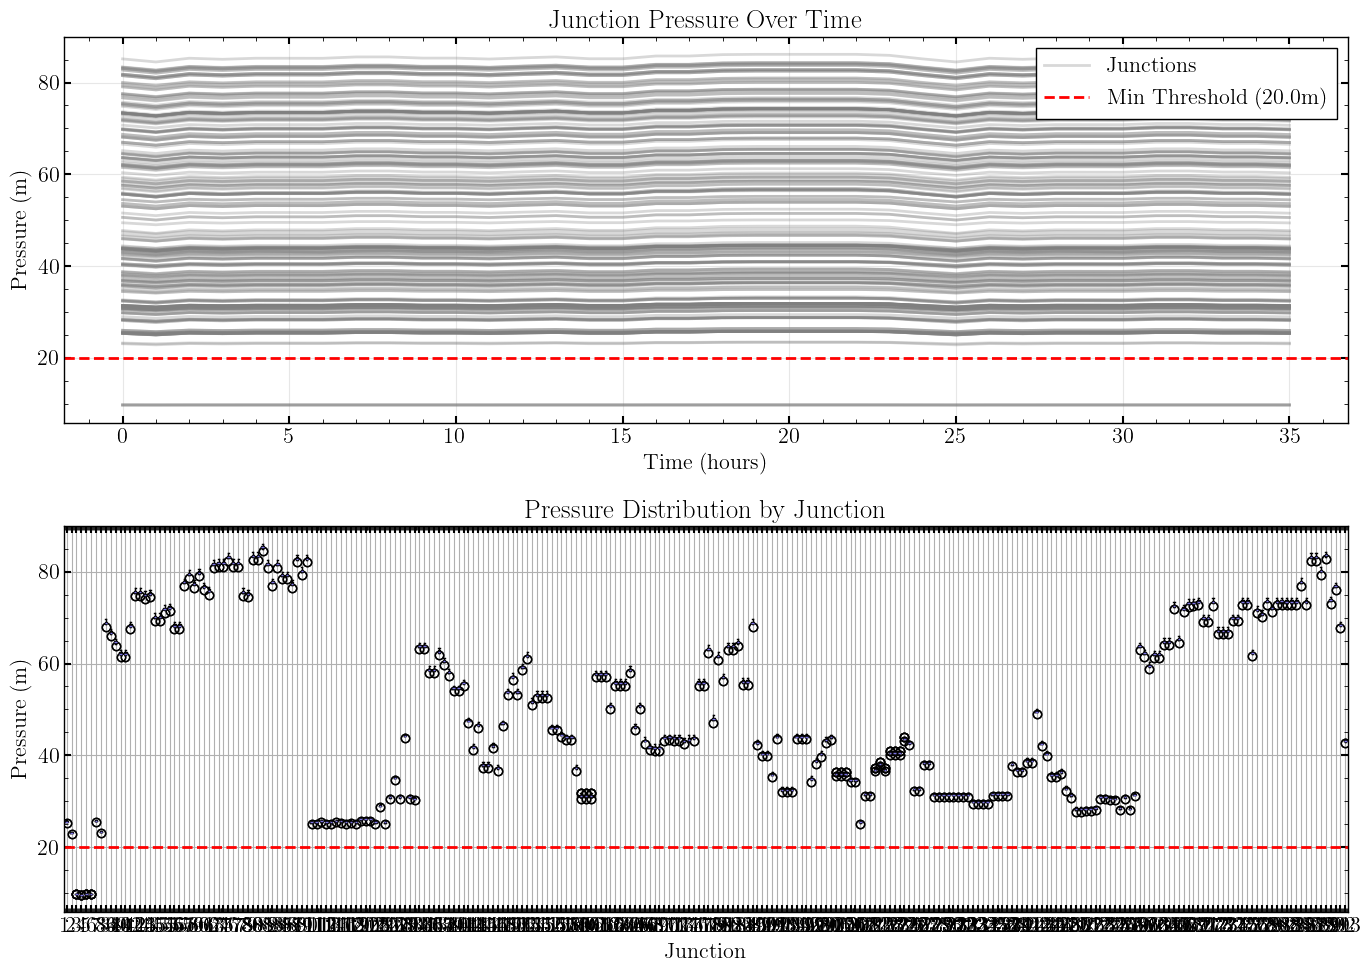

In [6]:
if run_dir:
    # Get junction columns (exclude tanks and reservoirs)
    junction_cols = [c for c in pressure_df.columns if c in wn.junction_name_list]
    
    # Plot style if too many junctions
    is_too_many = len(junction_cols) > 10
    plot_style = {'color': 'gray', 'alpha': 0.3} if is_too_many else {'alpha': 0.8}

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Pressure over time for all junctions
    ax1 = axes[0]
    for i, col in enumerate(junction_cols):
        label = ("Junctions" if i == 0 else "_nolegend_") if is_too_many else col
        ax1.plot(pressure_df.index, pressure_df[col], label=label, linewidth=2, **plot_style)


    # Add threshold line
    threshold = config.get('metrics', {}).get('min_pressure_threshold', 20.0)
    if 'pressure' in summary:
        threshold = 20.0  # default
    ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Min Threshold ({threshold}m)')
    
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Pressure (m)')
    ax1.set_title('Junction Pressure Over Time')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Pressure distribution (boxplot)
    ax2 = axes[1]
    if junction_cols:
        pressure_df[junction_cols].boxplot(ax=ax2)
        ax2.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Min Threshold')
        ax2.set_xlabel('Junction')
        ax2.set_ylabel('Pressure (m)')
        ax2.set_title('Pressure Distribution by Junction')
    
    plt.tight_layout()
    plt.show()

## 3. Demand Profile

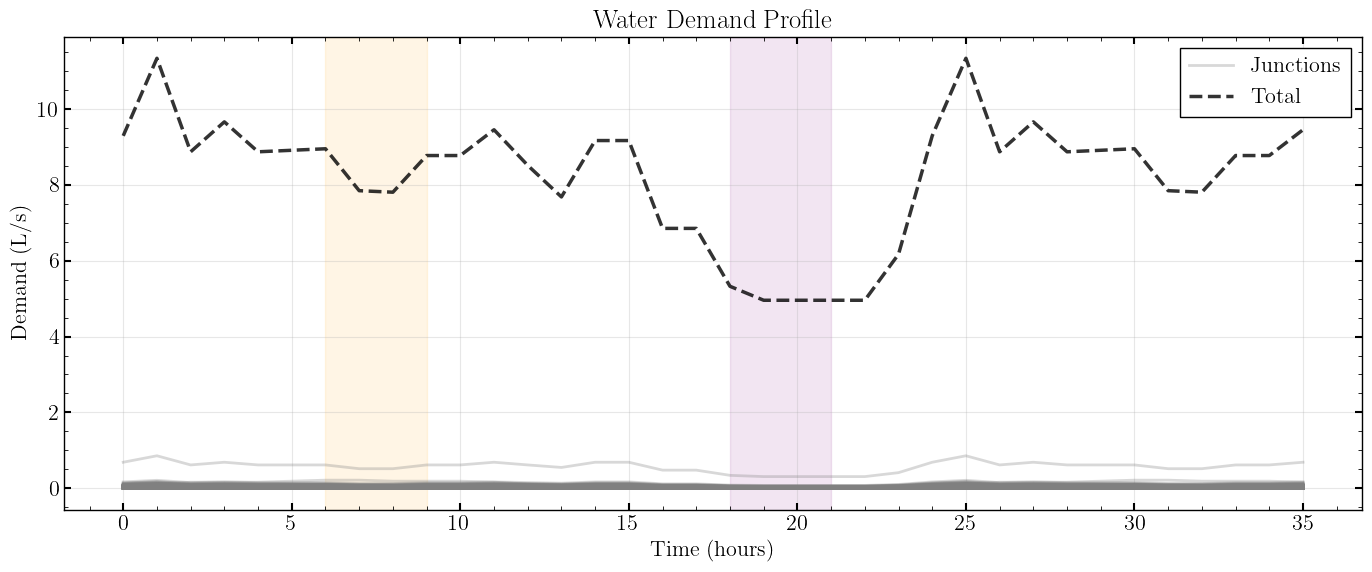

In [7]:
if run_dir:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot demand for each junction
    junction_cols = [c for c in demand_df.columns if  c in wn.junction_name_list]
    
    # Plot style if too many junctions
    is_too_many = len(junction_cols) > 10
    plot_style = {'color': 'gray', 'alpha': 0.3} if is_too_many else {'alpha': 0.8}

    
    # Pressure over time for all junctions
    for i, col in enumerate(junction_cols):
        label = ("Junctions" if i == 0 else "_nolegend_") if is_too_many else col
        ax.plot(demand_df.index, demand_df[col] * 1000, label=label, linewidth=2, **plot_style) # Convert to L/s
    
    # Plot total demand
    total_demand = demand_df[junction_cols].sum(axis=1) * 1000
    ax.plot(demand_df.index, total_demand, 'k--', linewidth=2.5, label='Total', alpha=0.8)
    
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Demand (L/s)')
    ax.set_title('Water Demand Profile')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Highlight peak hours
    ax.axvspan(6, 9, alpha=0.1, color='orange', label='Morning Peak')
    ax.axvspan(18, 21, alpha=0.1, color='purple', label='Evening Peak')
    
    plt.tight_layout()
    plt.show()

## 4. Flow in Pipes

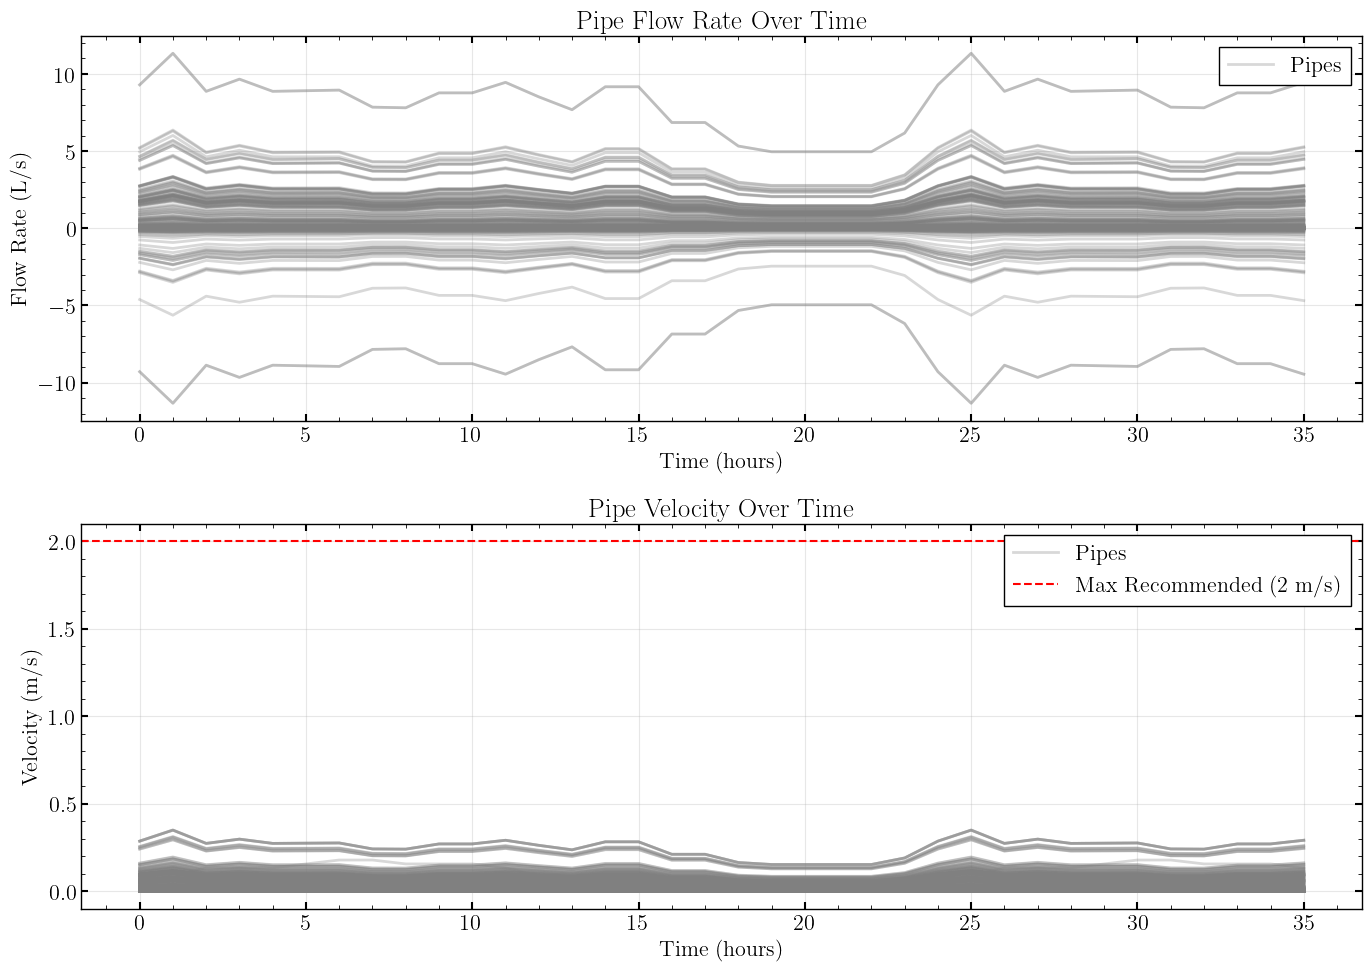

In [44]:
if run_dir:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    pipe_cols = [c for c in flowrate_df.columns if c in wn.pipe_name_list]
    

    # Plot style if too many pipes
    is_too_many = len(pipe_cols) > 10
    plot_style = {'color': 'gray', 'alpha': 0.3} if is_too_many else {'alpha': 0.8}

    # Flowrate over time
    ax1 = axes[0]
    # for col in pipe_cols:
    #     ax1.plot(flowrate_df.index, flowrate_df[col] * 1000, label=col, linewidth=2)
    
    ax1 = axes[0]
    # Flowrate over time for all pipes
    for i, col in enumerate(pipe_cols):
        label = ("Pipes" if i == 0 else "_nolegend_") if is_too_many else col
        ax1.plot(flowrate_df.index, flowrate_df[col] * 1000, label=label, linewidth=2, **plot_style) # Convert to L/s
    
    
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Flow Rate (L/s)')
    ax1.set_title('Pipe Flow Rate Over Time')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Velocity over time
    velocity_df.index = velocity_df.index.astype(float) / 3600  # Convert to hours
    # for col in pipe_cols:
    #     ax2.plot(velocity_df.index, velocity_df[col], label=col, linewidth=2)


    ax2 = axes[1]
    # Velocity over time for all pipes
    for i, col in enumerate(pipe_cols):
        label = ("Pipes" if i == 0 else "_nolegend_") if is_too_many else col
        ax2.plot(velocity_df.index, velocity_df[col], label=label, linewidth=2, **plot_style)
    
    
    ax2.axhline(y=2.0, color='red', linestyle='--', linewidth=1.5, label='Max Recommended (2 m/s)')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel(f'Velocity (m/s)')
    ax2.set_title('Pipe Velocity Over Time')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Tank Levels (if present)

In [45]:
if run_dir:
    tank_cols = [c for c in head_df.columns if c in wn.tank_name_list]
    
    if tank_cols:
        fig, ax = plt.subplots(figsize=(14, 6))
        
        head_df.index = head_df.index.astype(float) / 3600  # Convert to hours
        for col in tank_cols:
            ax.plot(head_df.index, head_df[col], label=col, linewidth=2.5)
        
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('Head / Water Level (m)')
        ax.set_title('Tank Level Over Time')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No tanks in the network.")

No tanks in the network.


## 6. Performance Metrics Summary

In [46]:
if run_dir:
    print("=" * 50)
    print("SIMULATION METRICS SUMMARY")
    print("=" * 50)
    
    if 'pressure' in summary['metrics']:
        p = summary['metrics']['pressure']
        print(f"\n📊 Pressure Statistics:")
        print(f"   Minimum: {p['min']:.2f} m")
        print(f"   Maximum: {p['max']:.2f} m")
        print(f"   Mean:    {p['mean']:.2f} m")
    
    if 'service_satisfaction' in summary['metrics']:
        print(f"\n✅ Service Satisfaction: {summary['metrics']['service_satisfaction']:.1%}")
    
    if 'num_critical_nodes' in summary['metrics']:
        print(f"⚠️  Critical Nodes: {summary['metrics']['num_critical_nodes']}")
        if summary['metrics'].get('critical_nodes'):
            print(f"   Nodes: {', '.join(summary['metrics']['critical_nodes'])}")
    
    if 'flow' in summary['metrics']:
        f = summary['metrics']['flow']
        print(f"\n🌊 Flow Statistics:")
        print(f"   Max Flow Rate: {f['max_flowrate_m3s']*1000:.2f} L/s")
        print(f"   Max Velocity:  {f['max_velocity_ms']:.2f} m/s")
    
    if 'total_demand_m3' in summary['metrics']:
        print(f"\n💧 Total Demand Delivered: {summary['metrics']['total_demand_m3']:.2f} m³")
    
    print("\n" + "=" * 50)

SIMULATION METRICS SUMMARY

📊 Pressure Statistics:
   Minimum: 9.60 m
   Maximum: 86.15 m
   Mean:    50.59 m

✅ Service Satisfaction: 98.5%
⚠️  Critical Nodes: 4
   Nodes: 3, 4, 5, 6

🌊 Flow Statistics:
   Max Flow Rate: 11.34 L/s
   Max Velocity:  0.35 m/s

💧 Total Demand Delivered: 0.30 m³

